# Create a surrogate model for our problem  
We will use first a physical approximation of the solution using Forward Euler 
We will then refine the solution using a NN in a multi level approach 

In [19]:
import numpy as np
import matplotlib as plt
import os 
import timeit
from scipy.stats import uniform
from numba import jit 
import tensorflow as tf

### Create physical coarse approximation of the solution

Define help function to compute the total stiffness

In [20]:
@jit(nopython=True) # Use nopython mode for best performance and simplest compilation
def compute_stiffness(w, th , E , l1 , l2 , oe): 
    """
    Inputs:
    w - Beam width
    th - Beam thickness 
    E - Young's modulus of the beam material
    l1 - Length of the longer beams
    l2 - Length of the shorter beams
    oe - Overetch affecting the effective width of the beam

     Output:
     kTotal - Total stiffness of the folded beam structure
    """
    effectiveWidth = w - 2*oe
    J = (1/12) * th * effectiveWidth**3
    #Stiffness of individual beams based on their length
    k1 = 12 * E * J / (l1**3 * 4)
    k2 = 12 * E * J / (l2**3 * 2)
    kTotal = 2 / (1/k1 + 1/k2)
    
    return kTotal


In [21]:
@jit(nopython=True)
def fringing_coeff( G, W ,L):
    return (1+ G/np.pi/W + G/np.pi/W*np.log(2*np.pi*W/G))*(1+ G/np.pi/L + G/np.pi/L*np.log(2*np.pi*L/G))
    
    

In [22]:
@jit(nopython=True)
def coarse_model(params):
    """
    - Inputs:
    - parameters[0] : Overetch 
    - parameters[1] : Offset
    - parameters[2] : Thickness

    - Output:
    - C : An array containing the computed difference of capacitance 
    """
    # Time parameters
    t0 = 0                    # Initial time.
    tf = 0.0015-1e-5          # Final time.
    dt =1e-5                # Time step size.

    # Stiffness parameters
    l1 = 221.4*1e-6              # Lenght of the longer beam 
    l2 = 110*1e-6            # Length of the shorted beam
    E  = 160*1e9               # Young Modulus 
    w  = 2.8*1e-6              # Width 

    # Force parameters 
    phi = lambda t: 0.9*(1-np.cos(2*np.pi*2500*t)) if t < 2/2500 else 0 # Voltage in the right electrodes
    s   = 101*1e-6             # param for the surface 
    dp  =1.2*1e-6                # Distance from the plates with Overetch and Offset = 0 

    # Mass parameters
    rho = 2320                 # Density of the mass.
    A   = 84*1e-9              # Area of the component

    # Damping parameters 
    alpha = 31440            # Damping coefficient alpha. 31400
    beta  =  0               # Damping coeff beta 

    # Input Parameters 
    oe = params[0]*1e-6
    of = params[1]*1e-6
    th = params[2]*1e-6 # ricorda di rimettere 6
   
    eps0 = 8.854*1e-12       # Dielectric permittivity constant
    eps1 = 1.000             # Relative dielectric permittivity of air.

    # Compute the distance between the faces of electrodes and the sensor
    dl = dp+2*oe+of
    dr = dp+2*oe-of
    # Compute the surface of the electrode 
    S = th * (s - 2*oe) * 10  # multiply by ten since we have 10 condensators
    
    # Initial conditions
    u0 = 0  # Initial displacement
    v0 = 0  # Initial velocity
    N = int((tf - t0) / dt)

    # Initialization
    u = np.zeros((N+1))  # displacement
    v = np.zeros((N+1))  # velocity
    C = np.zeros((N+1))  # capacitance
    u[0] = u0
    v[0] = v0
    C[0] = eps1*eps0*S*(1/(dr)*fringing_coeff( dr, s-2*oe ,th) - 1/(dl)*fringing_coeff( dl, s-2*oe ,th))

    # Compute the stiffness
    k = compute_stiffness(w, th , E , l1 , l2 , oe) 
   
    # Compute mass
    m = rho * A * th
    # Compute Damping 
    damp = alpha* m + beta* k

    # Precompute phi values to avoid redundant computation
    k1 =  0.5 * eps0 * eps1 * S
    k2 = eps1*eps0*S
    F_values = np.array([phi(n * dt) for n in range(N)])**2 * k1

    # Time-stepping loop using Forward Euler scheme
    for n in range(N) :
        u_n = u[n]
        v_n = v[n]
        u_new = u_n + dt * v_n
        # Compute the value of the input voltage at time t = n*dt 
        F = F_values[n]/((dr-u_n)**2)
        v[n+1] = v_n + dt * ( F - damp*v_n - k*u_n )/m
        # Compute the difference of capacitance
        C[n+1] = k2*(1/(dr-u_new)*fringing_coeff( dr-u_new, s-2*oe ,th) - 1/(dl+u_new)*fringing_coeff( dl+u_new, s-2*oe ,th))
        u[n+1] = u_new

    return C*1e15*1.02

# Quality of the solution choosing a subsample of the coarse solution 

Select the true samples on which we want to test the corse model, compare them with the coarse model, choosing only one out od three samples 

In [23]:
# Standard library imports
import sys
# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
data_processor_I = preprocessing(CONFIGURATION_I)

# Extract test data 
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

# Which sample of the training set do wou want to take as experimental input?
sample = [5,11, 22, 38, 60]

# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
print('        Overetch,   Offset,   Thickness')
x_true


        Overetch,   Offset,   Thickness


array([[ 2.3053600e-01, -6.8871000e-02,  3.0351452e+01],
       [ 4.5057900e-01, -4.4200000e-04,  2.9471304e+01],
       [ 1.5078200e-01, -6.1468000e-02,  3.0962383e+01],
       [ 2.6249600e-01, -2.7814000e-02,  2.9626475e+01],
       [ 4.6478700e-01, -3.4692000e-01,  2.9295773e+01]])

Perform comparisons with different types of inputs of parameters 

The parameters used are: [ 0.230536 -0.068871 30.351452]


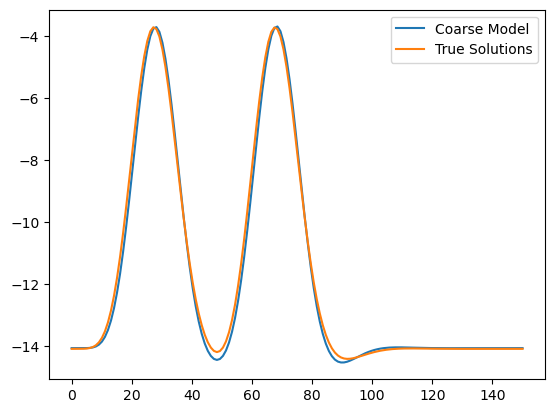

The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]


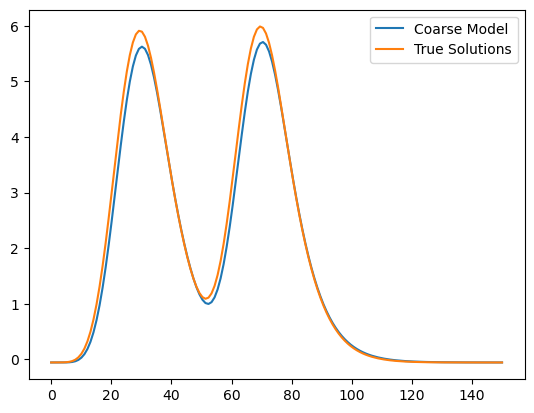

The parameters used are: [ 0.150782 -0.061468 30.962383]


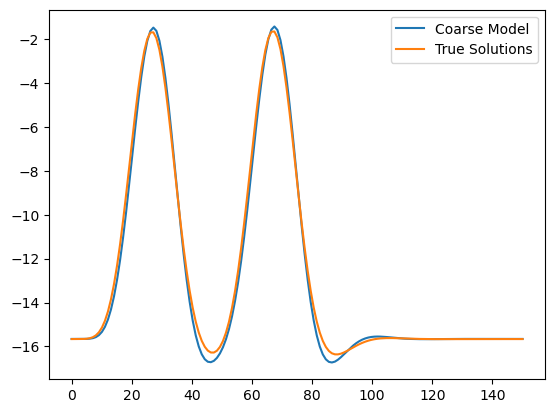

The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]


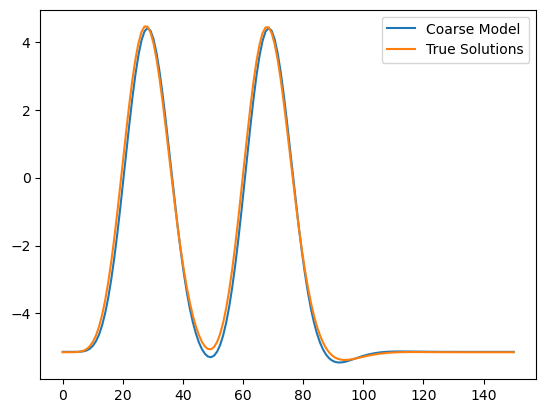

The parameters used are: [ 0.464787 -0.34692  29.295773]


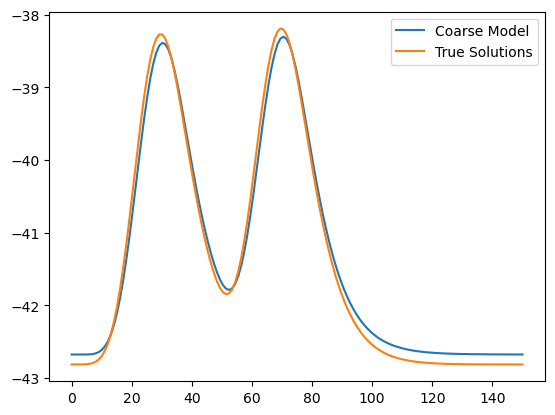

Mean absolute percentage error for the simulations are:
 [0.01478697 0.06420755 0.01865394 0.03882397 0.00342058]


In [24]:
ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    res = coarse_model(x)#[1:150:3]
    x3 = np.linspace(0,150,150)
    x = np.linspace(0,150,150)
    plt.plot(x3, res)
    plt.plot(x,y_true[index])
    plt.legend(['Coarse Model', 'True Solutions'])
    plt.show()
    ratio.append(  np.linalg.norm((res - y_true[index]), ord=1)  / np.linalg.norm(( y_true[index]), ord=1) )

#plt.plot(y_true[-1]-res)
#plt.show()
print('Mean absolute percentage error for the simulations are:\n', np.array(ratio) ) 
    

# Multilevel NN 

Let us now train a simplified NN compared to the fine models that takes as input parameter the output of the coarse model ( One Out of Three elements of the coarse solution )

First we have to create a dataset of the coarse sol for all the data we have 

In [25]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [26]:
# Collecting traing and Testing Data
X_train = data_processor_I.X_train
X_test = data_processor_I.X_test
y_train = data_processor_I.y_train
y_test = data_processor_I.y_test

In [27]:
coarse_y_train = []
coarse_y_test = []
for x in X_train:  
    coarse_y_train.append(coarse_model(x)[0:150:3])
for x in X_test:
    coarse_y_test.append(coarse_model(x)[0:150:3])

# Concatenate input parameters and coarse solutions
X_train_combined = np.concatenate((X_train, coarse_y_train), axis=1)
X_test_combined = np.concatenate((X_test, coarse_y_test), axis=1)

### Single Layer NN - One out of 3 

Initialize the weights matrix as a the linear interpolation between the subsample of the solutions 

In [28]:
# Define the initial weights matrix 
w = np.zeros((50,150))
for i in range(50):
    for j in range(150):
        if j == 3*i:
            w[i,j]=1
        if j == 3*i-1 or j == 3*i+1 and j<150:
            w[i,j]=2/3
        if j == 3*i-2 or j == 3*i +2 and j<150 :
            w[i,j]=1/3
w[49,149] = 1
w[49,148] = 1
weight_matrix = [ np.vstack([np.zeros((3,150)),w ] ), np.zeros(150) ]

Train or load the Neural Network

In [29]:
Training = False

num_samples = 640
num_parameters = 3
num_coarse_values = 50



# Define the neural network model
model_LF_NN_oo3 = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])

# Set the initial weights for the dense layer
model_LF_NN_oo3.layers[0].set_weights(weight_matrix)

if Training: 
       
       # Define the optimizer with an initial learning rate
       initial_learning_rate = 1e-3
       optimizer = Adam(learning_rate=initial_learning_rate) 

       # Compile the model with the optimizer
       model_LF_NN_oo3.compile(optimizer=optimizer, loss='mean_squared_error')

       # Define a learning rate scheduler
       learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=2e-6)

       # Concatenate input parameters and coarse solutions
       X_train_combined = np.concatenate((X_train, coarse_y_train), axis=1)
       X_test_combined = np.concatenate((X_test, coarse_y_test), axis=1)
    

       # Train the model
       history = model_LF_NN_oo3.fit(X_train_combined, y_train, epochs = 3000, batch_size=64, validation_data= (X_test_combined, y_test), callbacks=learning_rate_scheduler)

       model_LF_NN_oo3.save('./models/model_LF_NN_oo3.keras')

       # Plot the errors 
       plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
       tot_train = len(history.history['loss'])
       tot_valid = len(history.history['val_loss']) 
       valid_freq = int(tot_train / tot_valid)
       plt.plot(np.arange(tot_train), history.history['loss'], 'b-', label='Training loss', linewidth=2)
       plt.plot(valid_freq * np.arange(tot_valid), history.history['val_loss'], 'r--', label='Validation loss', linewidth=2)
       plt.yscale('log')
       plt.xlabel('Epochs', fontsize=14)
       plt.ylabel('Loss', fontsize=14)
       plt.legend(fontsize=12)
       plt.title('Training and Validation Loss', fontsize=16)
       plt.grid(True)
       plt.show()


# Load the model
model_LF_NN_oo3 = load_model('./models/model_LF_NN_oo3.keras')


/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Save directly the weights and bias to use directly in computing the soliution making the coarse model faster. This is possibile since we are using a single layer (0 Hidden NN) with linear activation function.

Consequently the result is W*x + b where:

W is the weight matrix of the NN  
b in the bias vector  
X is the coarse solution obtained with Euler Forward

In [30]:
np.save('./models/weights_NN_oo32.npy', model_LF_NN_oo3.layers[0].get_weights()[0])
np.save('./models/bias_NN_oo32.npy', model_LF_NN_oo3.layers[0].get_weights()[1])

Load the model  
the normal way ( we simply use the pre-trained NN )  
the optimized way where the weights and bias terms are directly used as matrix multiplication 


In [31]:
# Import the function coarse_model
sys.path.append('../../tests/Xaccelerometer_geometric/models')
from coarse_model import *

model_lf_oo3 = create_model_LF_NN_oo3(model_LF_NN_oo3)
model_lf_oo3_opt = create_model_LF_NN_oo3_opt()


The parameters used are: [ 0.230536 -0.068871 30.351452]


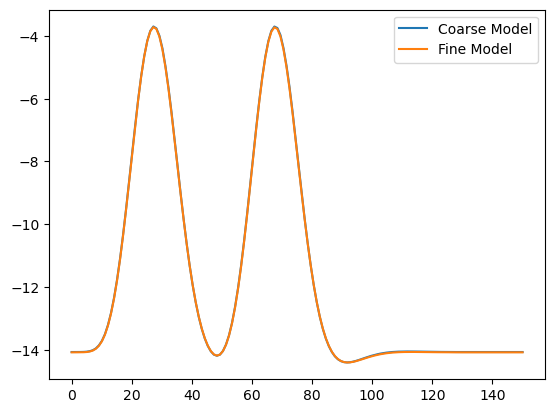

The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]


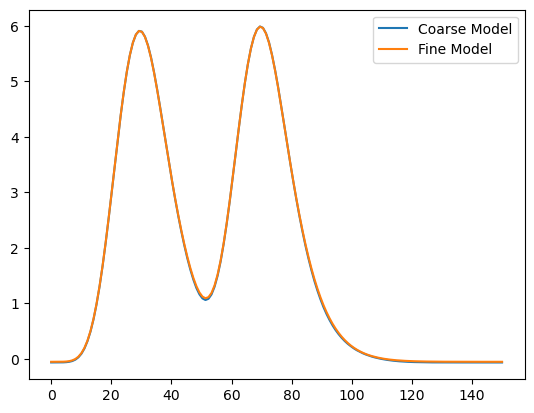

The parameters used are: [ 0.150782 -0.061468 30.962383]


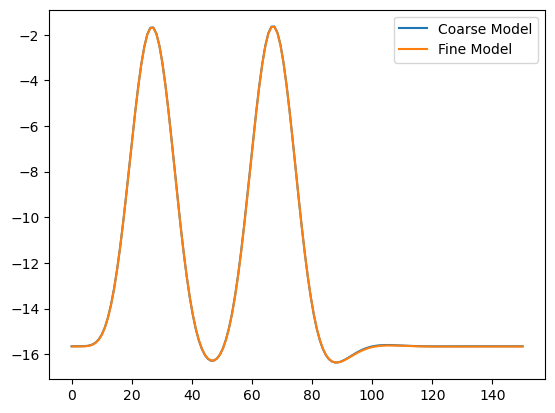

The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]


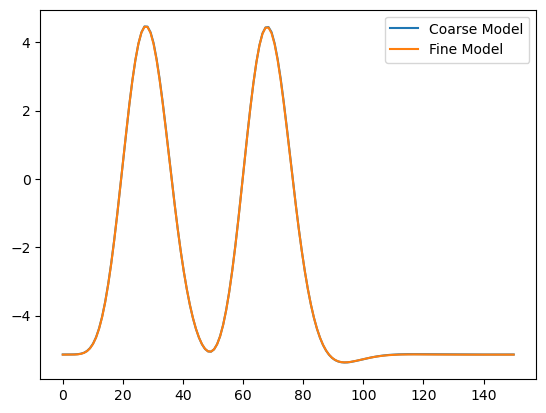

The parameters used are: [ 0.464787 -0.34692  29.295773]


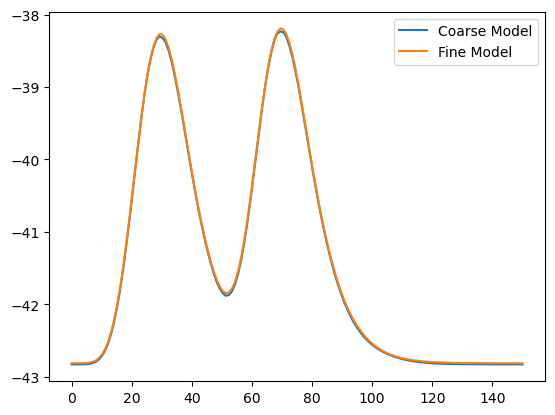

Mean absolute percentage error for the simulations are:
 [0.00135559 0.00720274 0.00127222 0.0018041  0.00052355]


In [32]:
ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    res = model_lf_oo3_opt(x)
    x = np.linspace(0,150,150)
    plt.plot(x, res)
    plt.plot(x,y_true[index])
    plt.legend(['Coarse Model', 'Fine Model'])
    plt.show()
    ratio.append(  np.linalg.norm((res - y_true[index]), ord=1)  / np.linalg.norm(( y_true[index]), ord=1) )

#plt.plot(y_true[-1]-res)
#plt.show()
print('Mean absolute percentage error for the simulations are:\n', np.array(ratio) ) 
    

### Evaluate the speed of the new models compared to the fine one 

In [33]:
# Initialize and load model
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

# Define forward function
forward_model = create_forward_model_function(data_processor_I, model_I)

In [34]:
import numpy as np
import tensorflow as tf
import timeit
 
# Define parameters x 
X = np.random.uniform(low=[0.1, -0.5, 29.0], high=[0.5, 0.5, 31.0], size=(10000, 3))

time = data_processor_I.time
X_rep = np.repeat(X, len(time), axis=0)
time_repeated = np.tile(time, len(X_rep) // len(time))
X_rep = np.column_stack((X_rep, time_repeated))
X_new = data_processor_I.scaler.transform(X_rep)
 
# Compute the coarse model predictions 
start_0 = timeit.default_timer() 
coarse_predictions = [coarse_model(X[i,:]) for i in range(10000)]
end_0 = timeit.default_timer()
 
 
# Measure time for coarse model predictions
start_time = timeit.default_timer()
# Use the one layer model to predict in one go rather than in a loop
res_coarse_oo2 = [model_lf_oo3(X[i,:]) for i in range(10000)]
end_time = timeit.default_timer()

# Measure time for coarse model predictions
start_time1 = timeit.default_timer()
# Use the one layer model to predict in one go rather than in a loop
res_coarse_oo3 = [model_lf_oo3_opt(X[i,:]) for i in range(10000)]
end_time1 = timeit.default_timer()
 
# Use the 6 layer model
start_time2 = timeit.default_timer()
res_fine = [forward_model(X[i,:]) for i in range(10000)]
end_time2 = timeit.default_timer()
 
print('Time Euler', (end_0-start_0)/10000)
print('Time NN one out of 3', (end_time-start_time)/10000)
print('Time NN one out of 3 Optimized', (end_time1-start_time1)/10000)
print('Time Fine', (end_time2 - start_time2)/10000)
print('\nThe speedup coefficient fine/Euler is:',(end_time2 - start_time2)/(end_0-start_0) )
print('\nThe speedup coefficient fine/oo3 is:', (end_time2 - start_time2)/(end_time-start_time))
print('\nThe speedup coefficient fine/oo3_opt is:', (end_time2 - start_time2)/(end_time1-start_time1))
print('\nThe speedup coefficient oo3/oo3_opt is:', (end_time - start_time)/(end_time1-start_time1))


Time Euler 7.077479199506343e-06
Time NN one out of 3 0.0004859145125024952
Time NN one out of 3 Optimized 1.4227050001500175e-05
Time Fine 0.0026435135750012707

The speedup coefficient fine/Euler is: 373.51061027288597

The speedup coefficient fine/oo3 is: 5.440285290898151

The speedup coefficient fine/oo3_opt is: 185.8089747855335

The speedup coefficient oo3/oo3_opt is: 34.15427038291549


#### Evaluate the accuracy of each model

In [35]:
X_test = data_processor_I.X_test
y_test = data_processor_I.y_test

# Initialize the vector of MSE for each prediciton 
Euler_mse = []
NN_mse = []
fine_mse = []


for i in range(len(X_test)):
    Euler_mse.append(np.mean((coarse_model(X_test[i,:])-y_test[i,:])**2))
    NN_mse.append(np.mean((model_lf_oo3_opt(X_test[i,:])-y_test[i,:])**2))
    fine_mse.append(np.mean((forward_model(X_test[i,:])-y_test[i,:])**2))

print('Euler MSE:', np.mean(Euler_mse))
print('NN MSE:   ', np.mean(NN_mse))
print('Fine MSE: ', np.mean(fine_mse))

Euler MSE: 0.21056394617396057
NN MSE:    0.0010493314239123836
Fine MSE:  0.0002919252155230866


#### Evaluate the sensitivity of the model with respect to the parameters

We will now compare the errors of the two coarse surrogate models compared to the fine model. 
The goal of this section is to highlight which parameter variation could most affect the error in the prediction using the coarse models. 
We note that this operation whould be preferably done with the true solution 

fixing thickness

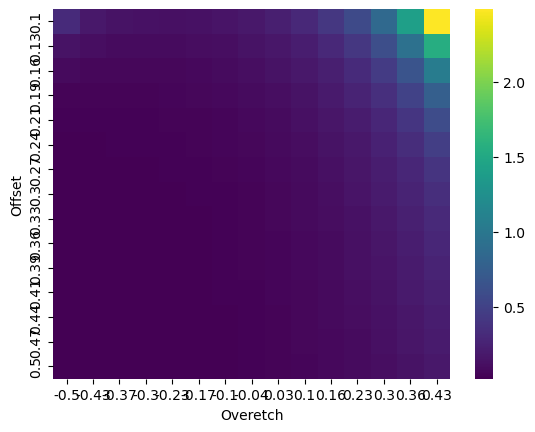

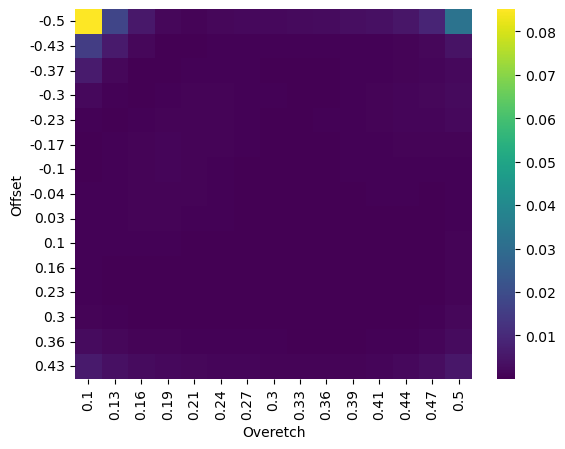

[0.1, 0.43, 30.0]


<function matplotlib.pyplot.show(close=None, block=None)>

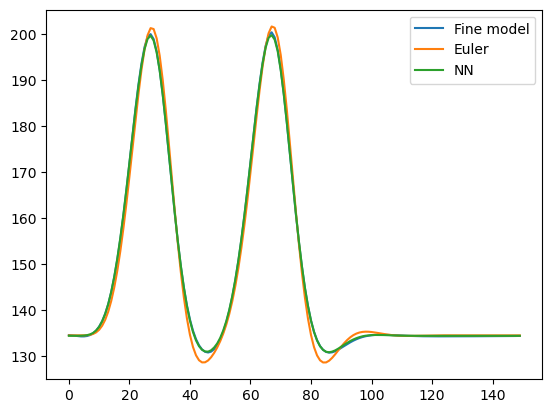

In [36]:
import seaborn as sns

# create a grid fixing the thickness
n = 15
th = 30.
overetch = np.linspace(0.1, 0.5, n)
offset = np.linspace(-0.5, 0.43, n)


# initalize the error matrix
err_euler = np.zeros((n,n))
err_NN = np.zeros((n,n))

for i, oe in enumerate(overetch):
    for j , of in enumerate(offset):
        x = [oe, of, th]
        err_euler[i,j] = np.mean((coarse_model(x)-forward_model(x))**2)
        err_NN[i,j] = np.mean((model_lf_oo3_opt(x)-forward_model(x))**2)


sns.heatmap(err_euler, cmap='viridis')
plt.yticks(ticks=np.arange(len(overetch)) + 0.5, labels=np.round(overetch,2), rotation = 'vertical')  # Adjust 0.5 offset if needed
plt.xticks(ticks=np.arange(len(offset)) + 0.5, labels=np.round(offset,2), rotation = 'horizontal')  
plt.xlabel('Overetch')
plt.ylabel('Offset')
plt.show()

sns.heatmap(err_NN, cmap='viridis')
plt.xticks(ticks=np.arange(len(overetch)) + 0.5, labels=np.round(overetch,2), rotation = 'vertical')  
plt.yticks(ticks=np.arange(len(offset)) + 0.5, labels=np.round(offset,2), rotation = 'horizontal')  
plt.xlabel('Overetch')
plt.ylabel('Offset')
plt.show()


x_bad = [overetch[0], offset[n-1], 30.]
print(x_bad)
plt.plot(forward_model(x_bad))
plt.plot(coarse_model(x_bad))
plt.plot(model_lf_oo3_opt(x_bad))
plt.legend(['Fine model', 'Euler', 'NN'])
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

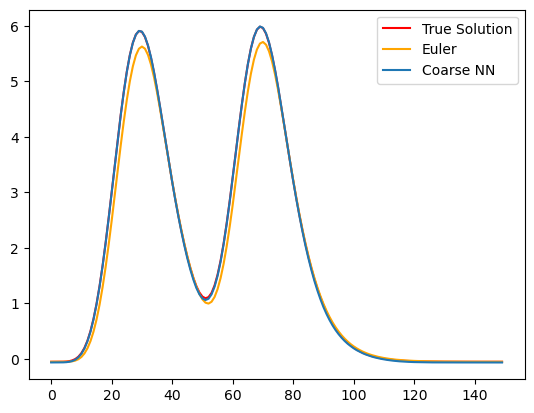

In [49]:
x_t, y_t = X_values[11], y_values[11]

plt.plot(y_t, color = 'red')
plt.plot(coarse_model(x_t), color = 'orange')
plt.plot(model_lf_oo3_opt(x_t))
plt.legend(['True Solution', 'Euler', 'Coarse NN'])
plt.show


fixing overetch

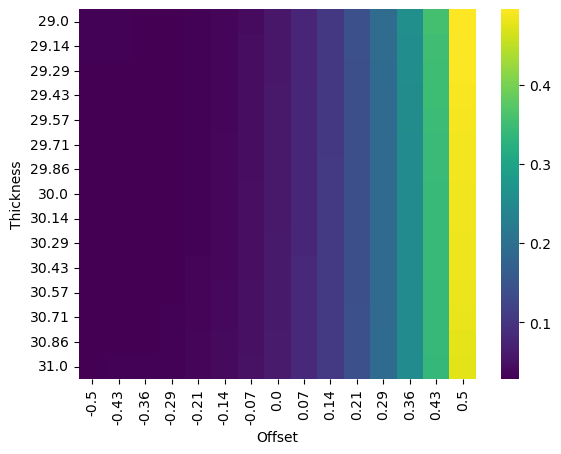

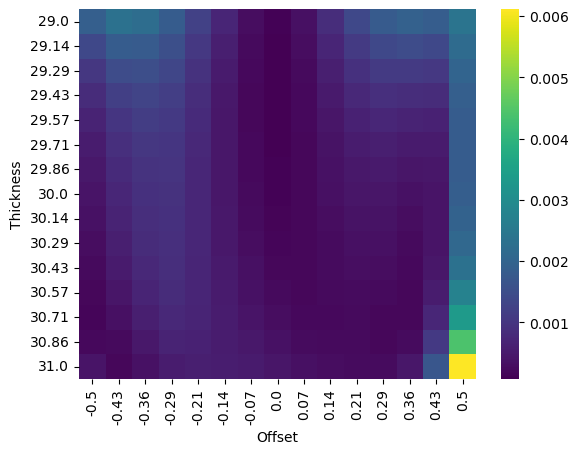

In [ ]:
# create a grid fixing the thickness
n = 15
oe = 0.3
thickness = np.linspace(29., 31., n)
offset = np.linspace(-0.5, 0.5, n)


# initalize the error matrix
err_euler = np.zeros((n,n))
err_NN = np.zeros((n,n))

for i, th in enumerate(thickness):
    for j , of in enumerate(offset):
        x = [oe, of, th]
        err_euler[i,j] = np.mean((coarse_model(x)-forward_model(x))**2)
        err_NN[i,j] = np.mean((model_lf_oo3_opt(x)-forward_model(x))**2)


sns.heatmap(err_euler, cmap='viridis')
plt.yticks(ticks=np.arange(len(thickness)) + 0.5, labels=np.round(thickness,2), rotation = 'horizontal')  # Adjust 0.5 offset if needed
plt.xticks(ticks=np.arange(len(offset)) + 0.5, labels=np.round(offset,2), rotation = 'vertical')  
plt.title('MSE Euler, fixed Overetch = 0.3')
plt.xlabel('Offset')
plt.ylabel('Thickness')
plt.show()

sns.heatmap(err_NN, cmap='viridis')
plt.yticks(ticks=np.arange(len(thickness)) + 0.5, labels=np.round(thickness,2), rotation = 'horizontal')  # Adjust 0.5 offset if needed
plt.xticks(ticks=np.arange(len(offset)) + 0.5, labels=np.round(offset,2), rotation = 'vertical')  
plt.title('MSE NN, fixed Overetch = 0.3')
plt.xlabel('Offset')
plt.ylabel('Thickness')
plt.show()



fixing Offset

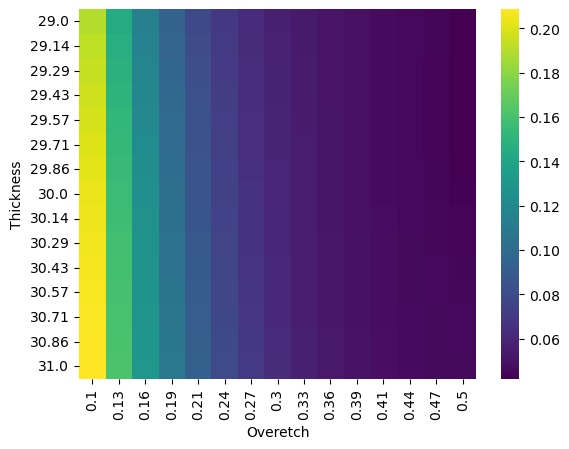

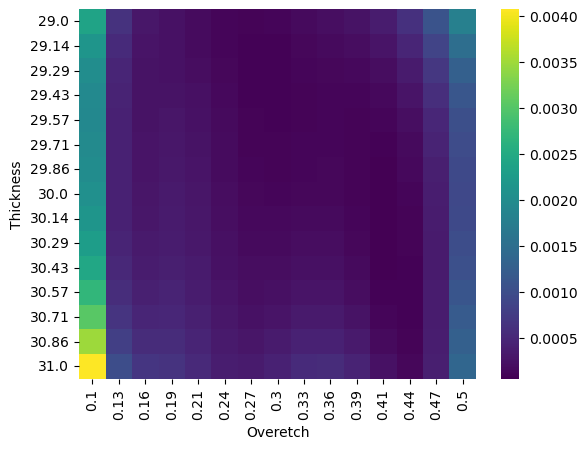

In [ ]:
# create a grid fixing the thickness
n = 15
of = 0.
thickness = np.linspace(29., 31., n)
overetch = np.linspace(0.1, 0.5, n)


# initalize the error matrix
err_euler = np.zeros((n,n))
err_NN = np.zeros((n,n))

for i, th in enumerate(thickness):
    for j , oe in enumerate(overetch):
        x = [oe, of, th]
        err_euler[i,j] = np.mean((coarse_model(x)-forward_model(x))**2)
        err_NN[i,j] = np.mean((model_lf_oo3_opt(x)-forward_model(x))**2)


sns.heatmap(err_euler, cmap='viridis')
plt.yticks(ticks=np.arange(len(thickness)) + 0.5, labels=np.round(thickness,2), rotation = 'horizontal')  # Adjust 0.5 offset if needed
plt.xticks(ticks=np.arange(len(overetch)) + 0.5, labels=np.round(overetch,2), rotation = 'vertical')  
plt.xlabel('Overetch')
plt.ylabel('Thickness')
plt.show()

sns.heatmap(err_NN, cmap='viridis')
plt.yticks(ticks=np.arange(len(thickness)) + 0.5, labels=np.round(thickness,2), rotation = 'horizontal')  # Adjust 0.5 offset if needed
plt.xticks(ticks=np.arange(len(overetch)) + 0.5, labels=np.round(overetch,2), rotation = 'vertical')  
plt.xlabel('Overetch')
plt.ylabel('Thickness')
plt.show()

